## Particle Filter with known correspondences

   ### The Mobile Robot
   <img src="images/PFRobotPicture.png" alt="Trial Image" width="250" style="float: right"/>
   
   * Consider a simple planar outdoor robot with IMU & RF Transponder
   * Let's say that the forward velocity and angular velocity are the control inputs
   * In other words the robot dynamics are modelled as unicycle
   * Simulation Frequency = model dynamics frequency = 10 Hz (0.01s)
   * Radio Update Frequency = Measurement Update = 5 Hz (0.05s)
   * State Vector $X_t$ = $\begin{pmatrix}
       x_t \\
       y_t \\
       \theta_t \\
       v_t
     \end{pmatrix}$
   * Input Vector $U_t$ = $\begin{pmatrix}
   v_t \\
   \omega_t
   \end{pmatrix}$
   * Measurement vector $Z_t$ = $\begin{pmatrix}
   r_t \\
   \end{pmatrix}$

### The Environment
<img src="images/rf-id.png" alt="Trial Image" width="250" style="float: right"/>

*  Tags are fixed in the environment with some known location. 
* Robot periodically sends out a query, and any tags within range respond by sending a reply.
* The robot can then estimate the distance to each responding tag by determining the time lapsed between sending the query and receiving the response.
* Since each tag transmits a unique ID number, distance readings are automatically associated with the appropriate tags,


### How many RF ids to place in the environment?
<img src="images/TrilaterationPrinciple.png" alt="Trial Image" width="500" style="float: center"/>

In [22]:
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

In [23]:
# Estimation parameter of PF - Unceetainity in motion & measurement model
Q = np.diag([2.0, np.deg2rad(40.0)]) ** 2  # input error
R = np.diag([0.2]) ** 2  # range error

In [24]:
#  Simulation parameter - Uncertainity in measurements
Q_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2
R_sim = np.diag([0.2]) ** 2

In [25]:
DT = 0.1 # Simulation Time Step

### System Dynamics
* $x_t = x_{t-1} + v_t \cos(\theta_t) dt$
* $y_t = y_{t-1} + v_t \sin(\theta_t) dt$
* $\theta_t = \theta_{t-1} + \omega_t \times dt$
* For $X_t = A X_{t-1} + B U_t$:
    - $ A = \begin{bmatrix} 
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0
       \end{bmatrix}$
    - $ B = \begin{bmatrix}
        \cos(\theta_t)dt & 0 \\
        \sin(\theta_t)dt & 0 \\
        0 & dt \\
        1 & 0
        \end{bmatrix} $
* $v_{err} = v - \hat{v}$
* $\omega_{err} = \omega - \hat{\omega}$
* $p(x_t|u_t,x_{t-1}) = \mathcal{N}(\mu, \Sigma)$
where,

    $\mu = \begin{pmatrix}
    v_{err} \\
    \omega_{err}
    \end{pmatrix}$
    
    $\Sigma = \begin{bmatrix}
    \sigma_v & 0 \\
    0 & \sigma_{\omega}
    \end{bmatrix}$

In [26]:
def motion_model(x, u):
    A = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[DT * math.cos(x[2, 0]), 0],
                  [DT * math.sin(x[2, 0]), 0],
                  [0.0, DT],
                  [1.0, 0.0]])

    x = A @ x + B @ u

    return x

### Measurement Model
* Transponder on the Robot would measure the distance to the RFID
* For Particle Filter, Let's use the value from the Probability Distribution (Gaussian) as the weight of the particle. 
* Larger the measured distance from the actual distance smaller is the weight
$ j = c^{i}_{t}$ 

$\hat{r} = \sqrt{(m_{j,x} - x)^2 + (m_{j,y} - y)^2}$

$r = \hat{r} + \epsilon; \quad \epsilon = \mathcal{N}(0,\sigma_d)$

$p(z^i_t|x_t) = w_i = \mathcal{N}(r - \hat{r}, \sigma_d)$

where,
$j$ = jth correspondence of ith measurement at t

$ \hat{r}$ = Expected Distance

$ m_{j,x}, m_{j,y}$ = Location of RFID in the world/map frame

$ x, y$ = Location of Robot at $t$

$w_i$ = Weight of each particle measured using a Gaussian based on difference from actual value

In [27]:
def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p

### Resampling - Low Variance Resampling
<img src="images/ResamplingAlgorithm.png" alt="Trial Image" width="500" style="float: center"/>

* Sample number uniformly between 0 and 1 of cumulative sum on weights and find which weight includes that number
* Particle with larger weight gets duplicated more

In [28]:
def resample(px, pw):
    """
    low variance re-sampling
    """

    w_cum = np.cumsum(pw)
    base = np.arange(0.0, 1.0, 1 / NP)
    re_sample_id = base + np.random.uniform(0, 1 / NP)
    indexes = []
    ind = 0
    for ip in range(NP):
        while re_sample_id[ip] > w_cum[ind]:
            ind += 1
        indexes.append(ind)

    px = px[:, indexes]
    pw = np.zeros((1, NP)) + 1.0 / NP  # init weight

    return px, pw

In [29]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v], [yawrate]])
    return u

In [30]:
def prediction(px, u):
    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        #  Predict with random input sampling
        ud1 = u[0, 0] + np.random.randn() * Q[0, 0] ** 0.5
        ud2 = u[1, 0] + np.random.randn() * Q[1, 1] ** 0.5
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud)
        px[:, ip] = x[:, 0]
        
    return px

In [31]:
def generate_noisy_control_input(u):
    ud1 = u[0, 0] + np.random.randn() * Q_sim[0, 0] ** 0.5
    ud2 = u[1, 0] + np.random.randn() * Q_sim[1, 1] ** 0.5
    ud = np.array([[ud1, ud2]]).T
    return ud

In [32]:
def generate_noisy_measurement(x_true, rf_id):
    """
    z[0,0] = actual measurement
    z[0,1] = ground_truth_x
    z[0,2] = ground_truth_y
    """
    z = np.zeros((0, 3))
    for i in range(len(rf_id[:, 0])):
        dx = x_true[0, 0] - rf_id[i, 0]
        dy = x_true[1, 0] - rf_id[i, 1]
        d = math.hypot(dx, dy)
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * R_sim[0, 0] ** 0.5  # add noise
            zi = np.array([[dn, rf_id[i, 0], rf_id[i, 1]]])
            z = np.vstack((z,zi))
    return z

In [34]:
def pf_update(px, pw, z):
    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        w = pw[0, ip]
        #  Calculate Importance Weight
        for i in range(len(z[:, 0])):
            if z[i,0] > 0.01:
                dx = x[0, 0] - z[i, 1]
                dy = x[1, 0] - z[i, 2]
                pre_z = math.hypot(dx, dy)
                dz = pre_z - z[i, 0]
                w = w * gauss_likelihood(dz, math.sqrt(R[0, 0]))
        pw[0, ip] = w
    pw = pw / pw.sum()  # normalize
    x_est = px.dot(pw.T)
    
    N_eff = 1.0 / (pw.dot(pw.T))[0, 0]  # Effective particle number
    if N_eff < NTh:
        px, pw = resample(px, pw)
        
    return x_est, px, pw

In [35]:
%matplotlib notebook

In [36]:
NP = 100  # Number of Particle
NTh = NP / 2.0  # Number of particle threshold for re-sampling
px = np.zeros((4, NP))  # Particles - 4 x NP
pw = np.zeros((1, NP)) + 1.0 / NP  # Particle weight - 1 x NP
MAX_RANGE = 20.0
SENSOR_UPDATE_RATE = 3

In [37]:
# Add some initial noise to provide diversity
for ip in range(NP):
    white_noise_s = 0.5 * np.random.randn(4,1)
    curr_part_state = np.array([px[:,ip]]).T
    noisy_state = curr_part_state + white_noise_s
    px[:,ip] = noisy_state[:,0]

In [38]:
# Create Simulation environment & simulate PF
SIM_TIME= 50.0
time = 0.0

# RF_ID positions [x, y]
rf_id = np.array([[10.0, 0.0],
                  [10.0, 10.0],
                  [0.0, 15.0],
                  [-5.0, 20.0]])

# State Vector [x y yaw v]'
x_est = np.zeros((4, 1))
x_true = np.zeros((4, 1))
x_dr = np.zeros((4, 1))  # Dead reckoning

# history
h_x_est = x_est
h_x_true = x_true
h_x_dr = x_true
h_x_particle = np.zeros((1,NP))
h_y_particle = np.zeros((1,NP))
h_x_measurement = []
h_y_measurement = []

count = 0
while SIM_TIME >= time:
    time += DT
    u = calc_input()
    
    # Generate Ground Truth
    x_true = motion_model(x_true, u)
    
    # Generate actual noisy control input
    ud = generate_noisy_control_input(u)
    x_dr = motion_model(x_dr, ud)
    
    # Propagate the particles
    px = prediction(px, ud)   
    
    if count % SENSOR_UPDATE_RATE == 0:
        # Generate actual noisy measurements
        z = generate_noisy_measurement(x_true, rf_id)
        
        # Perform PF Update
        x_est, px, pw = pf_update(px, pw, z)
        
        # Stack measurement for visualization
        current_meas_x = []
        current_meas_y = []
        for i in range(len(z[:, 0])):
            current_meas_x.append([x_true[0,0], z[i,1]])
            current_meas_y.append([x_true[1,0], z[i,2]]) 
        h_x_measurement.append(current_meas_x)
        h_y_measurement.append(current_meas_y)
    else:
        x_est = px.dot(pw.T)
    
    count = count + 1
    h_x_est = np.hstack((h_x_est, x_est))
    h_x_dr = np.hstack((h_x_dr, x_dr))
    h_x_true = np.hstack((h_x_true, x_true))
    x_p = np.array([px[0, :]])
    y_p = np.array([px[1, :]])
    h_x_particle = np.vstack((h_x_particle, x_p))
    h_y_particle = np.vstack((h_y_particle, y_p))

<IPython.core.display.Javascript object>


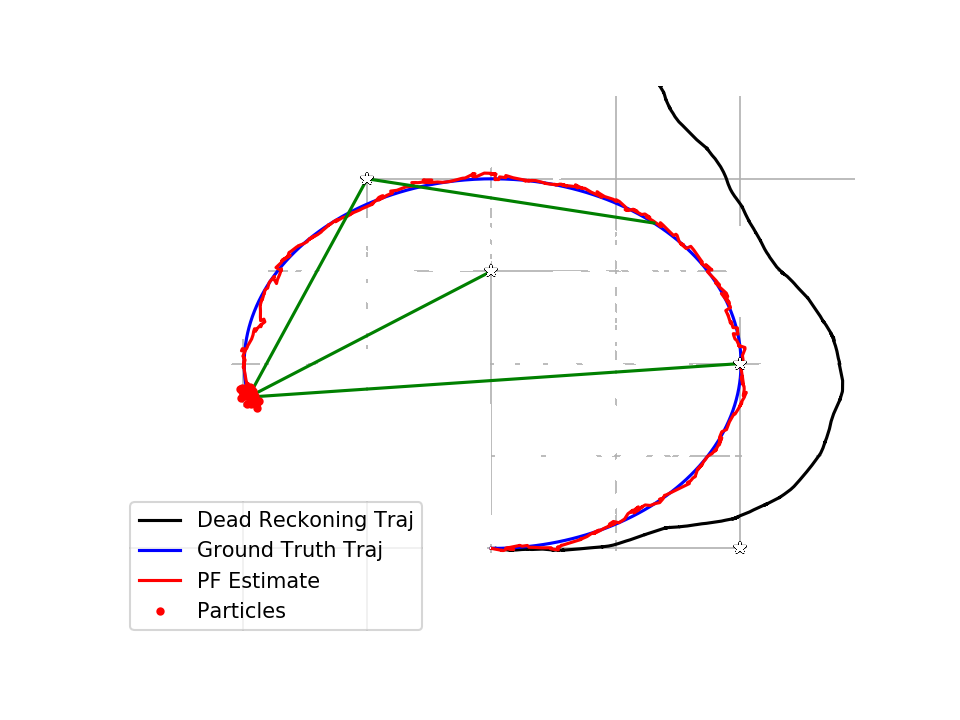

In [39]:
# Animate Particle Filter
measDatas = []
numRfIds = len(rf_id[:, 0])

fig, ax = plt.subplots()
predData, = plt.plot([],[],'-k', label='Dead Reckoning Traj')
gtData, = plt.plot([],[],'-b', label='Ground Truth Traj')
pfData, = plt.plot([],[],'-r', label='PF Estimate')
for _ in range(len(rf_id[:, 0])):
    measData, = plt.plot([],[],'-g')
    measDatas.append(measData)
    
particleData, = plt.plot([],[],'.r', label='Particles')
numFrames = 1000

frames=np.linspace(0, numFrames)
ind = [(int)(frame * h_x_particle.shape[0]/ numFrames) for frame in frames]
ind_meas = [(int)(frame * len(h_x_measurement)/ numFrames) for frame in frames]

def init():
    x_true = h_x_true[0,:]
    #y_true = h_x_true[1,:]
    ax.set_xlim([np.min(x_true) - 5, np.max(rf_id[:, 0]) + 5])
    ax.set_ylim([np.min(rf_id[:, 1]) - 5, np.max(rf_id[:, 1]) + 5])
    plt.plot(rf_id[:, 0], rf_id[:, 1], "*k")
    plt.title("Dead Reckoning vs PF vs Ground Truth")
    plt.legend()
    ax.grid(True)
    
def update(frameID):
    predData.set_data(h_x_dr[0,0:ind[frameID]], h_x_dr[1,0:ind[frameID]])
    gtData.set_data(h_x_true[0,0:ind[frameID]], h_x_true[1,0:ind[frameID]])
    pfData.set_data(h_x_est[0,0:ind[frameID]], h_x_est[1,0:ind[frameID]])
    particleData.set_data(h_x_particle[ind[frameID], :], h_y_particle[ind[frameID], :])
    if frameID % SENSOR_UPDATE_RATE == 0:
        for i in range(len(h_x_measurement[ind_meas[frameID]])):
           measDatas[i].set_data(h_x_measurement[ind_meas[frameID]][i], h_y_measurement[ind_meas[frameID]][i]) 
anim = FuncAnimation(fig, update, frames=numFrames, interval= 1000, init_func=init, blit=True)
plt.show()